![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 10. Regularized Generalized Linear Models (Gaussian)

Regularized regression methods are vital for managing high-dimensional datasets or multicollinearity. Techniques like Ridge, Lasso, and Elastic Net add a penalty term to the least squares objective, stabilizing and improving model performance, especially when traditional linear regression risks overfitting. In this tutorial, we will fit Regularized Generalized Linear Models (GLMs) for continuous (Gaussian) data in Python. We will start by examining regularization techniques and build models for Ridge, Lasso, and Elastic Net to understand their mathematical foundations. We will then explore the `scikit-learn` library, which streamlines fitting and cross-validating these models and optimizes the regularization parameter λ. We will evaluate each model’s performance using cross-validation and discuss the most suitable contexts for each technique. By the end of this tutorial, you will understand how to implement and interpret regularized GLM models for continuous data in Python from both foundational and practical perspectives.

## Overview

A regularized Generalized Linear Model (GLM) with a Gaussian distribution is essentially a regularized linear regression model. When the response variable (Y) follows a Gaussian (normal) distribution, the GLM simplifies to ordinary least squares (OLS) regression. Adding regularization modifies the objective function to penalize the size of the coefficients, aiming to prevent overfitting and improve model interpretability and generalizability.



***1. Standard Linear Regression (GLM with Gaussian Distribution)***

In a standard linear regression (GLM with a Gaussian distribution):

-   **Random Component**: The response variable $Y$ follows a normal distribution with mean $\mu$ and variance $\sigma^2$. $$   Y \sim \mathcal{N}(\mu, \sigma^2) $$

-   **Systematic Component**: We assume a linear relationship between predictors and the mean of the response:

  $$
  \mu = X \
  $$

  where $X$ is the matrix of predictors and $\beta$) is the vector of coefficients.

-   **Identity Link Function**: For Gaussian distributions, the link function $g(\mu) = \mu$, meaning $\mathbb{E}[Y] = X \beta$.

The objective function for linear regression is derived by maximizing the likelihood, which is equivalent to minimizing the **sum of squared errors (SSE)**:

$$ 
\mathcal{L}(\beta) = \sum_{i=1}^n (y_i - X_i \beta)^2
$$

***2. Regularized Linear Regression (Regularized Gaussian GLM)***

In regularized regression, we add a penalty term to the objective function to control the size of the coefficients ( $\beta$ ). The regularized objective function becomes:

$$
\mathcal{L}_{\text{regularized}}(\beta) = \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda P
$$

where:

- $\lambda \geq 0$ is the regularization parameter, controlling the amount of penalty.

$P(\beta)$ is the penalty function. Common choices include:

-   **L2 norm (Ridge Regression)**:

$$ 
P(\beta) = \|\beta\|_2^2 =\sum_{j=1}^p \beta_j^2
$$

-   **L1 norm (Lasso Regression**

$$
P(\beta) = \|\beta\|_1 = \sum_{j=1}^p |\beta_j|
$$

-   **Elastic Net**:

$$
P(\beta) = \alpha\|\beta\|_1 + (1 - \alpha) \|\beta\|_2^2 
$$

which combines L1 and L2 penalties.

***Ridge (L2) Regularization:***

For Ridge regression, the objective function is: 

$$
\mathcal{L}_{\text{ridge}}(\beta) = \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^p \beta_j^2 
$$

The L2 penalty shrinks the coefficients toward zero but does not set them exactly to zero, making it useful for models with many correlated predictors.

***Lasso (L1) Regularization***:

For Lasso regression, the objective function is: 

$$ 
\mathcal{L}_{\text{lasso}}(\beta) = \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^p |\beta_j|
$$

The L1 penalty encourages sparsity, meaning it tends to set some coefficients exactly to zero, which is useful for feature selection.

***Elastic Net Regularization***:

For Elastic Net, the objective function is a combination of both L1 and L2 penalties:

$$
\mathcal{L}_{\text{elastic net}}(\beta) = \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \left( \alpha \sum_{j=1}^p |\beta_j| + (1 - \alpha) \sum_{j=1}^p \beta_j^2 \right)
$$ 

Elastic Net allows you to balance between Lasso and regularization, providing both feature selection and coefficient shrinkage.

***Optimization***

The coefficients $\beta$ are estimated by minimizing the regularized objective function with respect to $\beta$. Depending on the penalty, different optimization techniques are used:

-   **Ridge**: Closed-form solutions (matrix inversion) or gradient descent.
-   **Lasso and Elastic Net**: Coordinate descent, which optimizes one parameter at a time, is typically used.

## Regularized GLM Regression Model from Scratch

To perform regularized regression (Ridge, Lasso, and Elastic Net) on synthetic data in Python without using any libraries, we need to manually implement each regularization method in the GLM framework. Here's how to proceed:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### Generate Synthetic Data

Create synthetic data using the following code:

In [2]:
# Generate Synthetic Data
np.random.seed(123)
n = 100
p = 10
X = np.random.normal(0, 1, (n, p))
beta = np.array([1, -1, 0, 0.5, -0.5] + [0] * (p - 5))
y = X @ beta + np.random.normal(0, 1, n)

print(f"Generated {n} samples with {p} features")
print(f"True coefficients: {beta}")

Generated 100 samples with 10 features
True coefficients: [ 1.  -1.   0.   0.5 -0.5  0.   0.   0.   0.   0. ]


### Coordinate Descent Algorithm for Regularized Regression

Next, we implement the coordinate descent algorithm to solve the regularized regression problem. The algorithm iteratively updates each coefficient by minimizing the objective function with respect to that coefficient while keeping the others fixed. The update rule depends on the type of regularization (Ridge, Lasso, or Elastic Net).

In [3]:
def coordinate_descent(X, y, lambda_, alpha, tol=1e-6, max_iter=1000):
    """
    Coordinate descent algorithm for regularized regression.
    
    Parameters:
    X: numpy array, predictors
    y: numpy array, response
    lambda_: float, regularization parameter
    alpha: float, mixing parameter (0=Ridge, 1=Lasso, between=Elastic Net)
    tol: float, convergence tolerance
    max_iter: int, maximum iterations
    
    Returns:
    beta: numpy array, estimated coefficients
    """
    n, p = X.shape
    beta = np.zeros(p)
    
    # Standardize features
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_scaled = (X - X_mean) / X_std
    
    # Center target
    y_mean = np.mean(y)
    y_centered = y - y_mean
    
    for iter_ in range(max_iter):
        beta_old = beta.copy()
        
        for j in range(p):
            # Calculate residual without j-th feature
            r_j = y_centered - X_scaled @ beta + beta[j] * X_scaled[:, j]
            
            # Calculate z_j and rho_j
            z_j = np.sum(X_scaled[:, j] ** 2)
            rho_j = np.sum(X_scaled[:, j] * r_j)
            
            # Update beta based on regularization type
            if alpha == 1:  # Lasso
                beta[j] = np.sign(rho_j) * max(abs(rho_j) - lambda_, 0) / z_j
            elif alpha == 0:  # Ridge
                beta[j] = rho_j / (z_j + lambda_)
            else:  # Elastic Net
                beta[j] = np.sign(rho_j) * max(abs(rho_j) - lambda_ * alpha, 0) / (z_j + lambda_ * (1 - alpha))
        
        # Check for convergence
        if np.sum(np.abs(beta - beta_old)) < tol:
            print(f"Converged after {iter_ + 1} iterations")
            break
    
    return beta

### Cross-Validation for Hyperparameter Tuning (including alpha)

We can perform cross-validation to select the best hyperparameters (alpha and lambda) for the regularized regression model. This involves splitting the data into k folds, training the model on k-1 folds, and evaluating it on the remaining fold. We repeat this process for different values of alpha and lambda to find the best combination.

In [4]:
def cv_glm(X, y, alpha_seq, lambda_seq, k=5):
    """
    Cross-validation for hyperparameter tuning.
    
    Parameters:
    X: numpy array, predictors
    y: numpy array, response
    alpha_seq: list, sequence of alpha values
    lambda_seq: list, sequence of lambda values
    k: int, number of folds
    
    Returns:
    dict with best_alpha, best_lambda
    """
    n = X.shape[0]
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    best_mse = float('inf')
    best_lambda = None
    best_alpha = None
    
    for alpha in alpha_seq:
        mse_vals = []
        
        for lambda_ in lambda_seq:
            fold_errors = []
            
            # Cross-validation for each fold
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                beta = coordinate_descent(X_train, y_train, lambda_, alpha)
                
                # Standardize validation data using training means/stds
                X_train_mean = np.mean(X_train, axis=0)
                X_train_std = np.std(X_train, axis=0)
                X_val_scaled = (X_val - X_train_mean) / X_train_std
                
                y_pred = X_val_scaled @ beta
                fold_errors.append(np.mean((y_val - y_pred) ** 2))
            
            mse_vals.append(np.mean(fold_errors))
        
        # Find the best lambda for the current alpha
        min_mse = min(mse_vals)
        if min_mse < best_mse:
            best_mse = min_mse
            best_lambda = lambda_seq[np.argmin(mse_vals)]
            best_alpha = alpha
    
    return {'best_alpha': best_alpha, 'best_lambda': best_lambda}

### Train Models for All Alpha Values

Finally, we can train the regularized regression models for all alpha values (0 for Ridge, 0.5 for Elastic Net, and 1 for Lasso) and select the best alpha and lambda based on cross-validation results. We then fit the final model using the best hyperparameters and evaluate its performance.

In [5]:
# Standardize X for better regularization performance
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_scaled = (X - X_mean) / X_std

# Train Models for All Alpha Values
alpha_values = [0, 0.5, 1]  # Ridge (0), ElasticNet (0.5), Lasso (1)
lambda_seq = np.logspace(-3, 1, 50)

# Find the best alpha and lambda
cv_results = cv_glm(X_scaled, y, alpha_values, lambda_seq, k=5)

# Best alpha and lambda
best_alpha = cv_results['best_alpha']
best_lambda = cv_results['best_lambda']

# Train the final model using the best alpha and lambda
final_beta = coordinate_descent(X_scaled, y, best_lambda, best_alpha)
y_pred = X_scaled @ final_beta

# Calculate performance metrics
mse = np.mean((y - y_pred) ** 2)
r_squared = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)

print(f"\nFinal Model (Best Alpha = {best_alpha} and Lambda = {best_lambda}):\n")
print(f"MSE: {mse}")
print(f"R-squared: {r_squared}")

Converged after 10 iterations
Converged after 10 iterations
Converged after 12 iterations
Converged after 10 iterations
Converged after 11 iterations
Converged after 10 iterations
Converged after 10 iterations
Converged after 12 iterations
Converged after 10 iterations
Converged after 11 iterations
Converged after 10 iterations
Converged after 10 iterations
Converged after 12 iterations
Converged after 10 iterations
Converged after 11 iterations
Converged after 10 iterations
Converged after 10 iterations
Converged after 12 iterations
Converged after 10 iterations
Converged after 11 iterations
Converged after 10 iterations
Converged after 10 iterations
Converged after 12 iterations
Converged after 10 iterations
Converged after 11 iterations
Converged after 10 iterations
Converged after 10 iterations
Converged after 12 iterations
Converged after 10 iterations
Converged after 11 iterations
Converged after 10 iterations
Converged after 10 iterations
Converged after 12 iterations
Converged 

### Visualize Coefficients

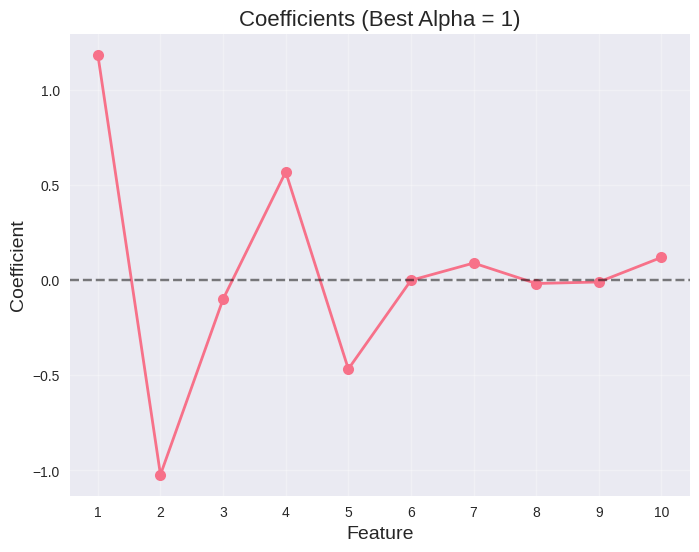

In [7]:
# Visualize Coefficients
coef_df = pd.DataFrame({
    'Feature': [f'X{i+1}' for i in range(len(final_beta))],
    'Coefficients': final_beta
})

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(final_beta) + 1), final_beta, 'o-', linewidth=2, markersize=8)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title(f'Coefficients (Best Alpha = {best_alpha})', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(range(1, len(final_beta) + 1))
plt.grid(True, alpha=0.3)
plt.show()

### Fit Ridge, Lasso, and Elastic Net models

Fit Ridge, Lasso, and Elastic Net models:

In [8]:
# Fit Ridge, Lasso, and Elastic Net models
ridge_beta = coordinate_descent(X_scaled, y, lambda_=best_lambda, alpha=0)
lasso_beta = coordinate_descent(X_scaled, y, lambda_=best_lambda, alpha=1)
elastic_net_beta = coordinate_descent(X_scaled, y, lambda_=best_lambda, alpha=best_alpha)

# Combine coefficients into a data frame
coef_summary = pd.DataFrame({
    'Predictor': [f'X{i+1}' for i in range(10)],
    'Ridge': np.round(ridge_beta, 3),
    'Lasso': np.round(lasso_beta, 3),
    'Elastic_Net': np.round(elastic_net_beta, 3)
})

print("Coefficient Comparison:")
print(coef_summary.to_string(index=False))

Converged after 10 iterations
Converged after 10 iterations
Converged after 10 iterations
Coefficient Comparison:
Predictor  Ridge  Lasso  Elastic_Net
       X1  1.184  1.187        1.187
       X2 -1.016 -1.023       -1.023
       X3 -0.131 -0.099       -0.099
       X4  0.586  0.570        0.570
       X5 -0.483 -0.467       -0.467
       X6 -0.005 -0.000       -0.000
       X7  0.119  0.091        0.091
       X8 -0.044 -0.017       -0.017
       X9 -0.040 -0.009       -0.009
      X10  0.148  0.121        0.121


### Predicted Values for Each Model

In [9]:
# Predicted values for each model
y_pred_ridge = X_scaled @ ridge_beta
y_pred_lasso = X_scaled @ lasso_beta
y_pred_elastic_net = X_scaled @ elastic_net_beta

### Evaluate Model Performance

In [10]:
def calculate_metrics(observed, predicted):
    """
    Calculate performance metrics for regression models.
    
    Parameters:
    observed: array-like, actual values
    predicted: array-like, predicted values
    
    Returns:
    dict with metrics
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    
    mse = np.mean((observed - predicted) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(observed - predicted))
    medae = np.median(np.abs(observed - predicted))
    r2 = 1 - np.sum((observed - predicted) ** 2) / np.sum((observed - np.mean(observed)) ** 2)
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'MedAE': medae,
        'R2': r2
    }

# Evaluate all models
models = ['Ridge', 'Lasso', 'Elastic Net']
predictions = [y_pred_ridge, y_pred_lasso, y_pred_elastic_net]

for i, model_name in enumerate(models):
    print(f"\n{model_name} Model Metrics:")
    metrics = calculate_metrics(y, predictions[i])
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Ridge Model Metrics:
RMSE: 0.8955
MAE: 0.7040
MSE: 0.8019
MedAE: 0.6171
R2: 0.8033

Lasso Model Metrics:
RMSE: 0.8990
MAE: 0.7070
MSE: 0.8082
MedAE: 0.5925
R2: 0.8018

Elastic Net Model Metrics:
RMSE: 0.8990
MAE: 0.7070
MSE: 0.8082
MedAE: 0.5925
R2: 0.8018


## Regularized GLM Regression Model in Python

To fit a Regularized Generalized Linear Model (GLM) with a Gaussian distribution (equivalent to linear regression) in Python, we will use the `scikit-learn` library.

### Install Required Python Packages

First, let's install the required packages. Most of these should be available in standard Python distributions, but you may need to install some:

In [17]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

print("Required packages imported successfully.")

Required packages imported successfully.


### Data

Our goal is to develop a GLM regression model to predict paddy soil arsenic (`SAs`) concentration using various irrigation water and soil properties. We have available data of 263 paired groundwater and paddy soil samples from arsenic contaminated areas in Tala Upazilla, Satkhira district, Bangladesh.

In [20]:
# Load data
url = "https://raw.githubusercontent.com/zia207/01_Generalized_Linear_Models_Python/refs/heads/main/Data/bd_soil_arsenic.csv?token=GHSAT0AAAAAADIWQ43XWV3A5YPTS7QR7XIA2GN357Q"
df = pd.read_csv(url)

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nDataset columns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (263, 29)

Dataset columns: ['ID', 'Longitude', 'Latitude', 'WAs', 'WP', 'WFe', 'WEc', 'WpH', 'WMg', 'WNa', 'WCa', 'WK', 'WS', 'SAs', 'SPAs', 'SAoAs', 'SAoFe', 'SpH', 'SEc', 'SOC', 'SP', 'Sand', 'Silt', 'Clay', 'Elevation', 'Year_Irrigation', 'Distance_STW', 'Land_type', 'Land_type_ID']

First few rows:
   ID  Longitude  Latitude    WAs     WP   WFe   WEc   WpH   WMg   WNa  ...  \
0   1    89.1134   22.7544  0.059  0.761  3.44  1.03  7.03  33.9  69.4  ...   
1   2    89.1232   22.7576  0.059  1.194  4.93  1.07  7.06  34.1  74.6  ...   
2   3    89.1281   22.7499  0.079  1.317  9.70  1.40  6.84  40.5  89.4  ...   
3   4    89.1296   22.7568  0.122  1.545  8.58  0.83  6.85  28.4  22.8  ...   
4   5    89.1312   22.7366  0.072  0.966  4.78  1.42  6.95  43.4  93.0  ...   

    SOC     SP  Sand  Silt  Clay  Elevation  Year_Irrigation  Distance_STW  \
0  1.66  13.79  16.3  44.8  38.9          3               14             5   
1  1.26  15.31  11.1  48.7  40.2          5      

#### Data Processing

In [21]:
# Data Processing
df_processed = df.copy()

# Select variables
selected_columns = ['WAs', 'WP', 'WFe', 'WEc', 'WpH', 'SAoFe', 'SpH', 'SOC', 
                   'Sand', 'Silt', 'SP', 'Elevation', 'Year_Irrigation', 
                   'Distance_STW', 'Land_type', 'SAs']
df_processed = df_processed[selected_columns]

# Convert Land_type to categorical
df_processed['Land_type'] = df_processed['Land_type'].astype('category')

# Create Silt_Sand variable
df_processed['Silt_Sand'] = df_processed['Silt'] + df_processed['Sand']

# Drop Silt and Sand columns
df_processed = df_processed.drop(['Silt', 'Sand'], axis=1)

# Reorganize columns
cols = list(df_processed.columns)
sas_index = cols.index('SAs')
silt_sand_index = cols.index('Silt_Sand')
land_type_index = cols.index('Land_type')

# Move SAs after Silt_Sand
cols.remove('SAs')
cols.insert(silt_sand_index + 1, 'SAs')

# Move Land_type after SAs
cols.remove('Land_type')
cols.insert(silt_sand_index + 2, 'Land_type')

df_processed = df_processed[cols]

# Display processed data
print("Processed dataset shape:", df_processed.shape)
print("\nProcessed dataset columns:")
print(df_processed.columns.tolist())
print("\nFirst few rows of processed data:")
print(df_processed.head())
print("\nLand_type distribution:")
print(df_processed['Land_type'].value_counts())

Processed dataset shape: (263, 15)

Processed dataset columns:
['WAs', 'WP', 'WFe', 'WEc', 'WpH', 'SAoFe', 'SpH', 'SOC', 'SP', 'Elevation', 'Year_Irrigation', 'Distance_STW', 'Silt_Sand', 'SAs', 'Land_type']

First few rows of processed data:
     WAs     WP   WFe   WEc   WpH  SAoFe   SpH   SOC     SP  Elevation  \
0  0.059  0.761  3.44  1.03  7.03   2500  7.74  1.66  13.79          3   
1  0.059  1.194  4.93  1.07  7.06   2670  7.87  1.26  15.31          5   
2  0.079  1.317  9.70  1.40  6.84   2160  8.03  1.36  15.54          4   
3  0.122  1.545  8.58  0.83  6.85   2500  8.07  1.61  16.28          3   
4  0.072  0.966  4.78  1.42  6.95   2060  7.81  1.26  14.20          5   

   Year_Irrigation  Distance_STW  Silt_Sand   SAs Land_type  
0               14             5       61.1  29.1       MHL  
1               20             6       59.8  45.1       MHL  
2               10             5       58.7  23.2       MHL  
3                8             8       56.3  23.8       MHL  
4 

#### Split Data to Training and Test Sets

We will use stratified random sampling to split the data into training and test sets, ensuring that each subgroup (based on Land_type) is proportionally represented.

In [22]:
# Set random seed for reproducibility
np.random.seed(11076)

# Stratified sampling based on Land_type
train_list = []
test_list = []

for land_type in df_processed['Land_type'].unique():
    land_type_data = df_processed[df_processed['Land_type'] == land_type]
    n_samples = len(land_type_data)
    n_train = int(0.70 * n_samples)  # 70% for training
    
    # Random sampling
    train_indices = np.random.choice(land_type_data.index, size=n_train, replace=False)
    test_indices = land_type_data.index[~land_type_data.index.isin(train_indices)]
    
    train_list.append(land_type_data.loc[train_indices])
    test_list.append(land_type_data.loc[test_indices])

# Combine the stratified samples
train = pd.concat(train_list, ignore_index=True)
test = pd.concat(test_list, ignore_index=True)

print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")
print(f"Total: {len(train) + len(test)}")

# Check stratification
print("\nLand_type distribution in training set:")
print(train['Land_type'].value_counts(normalize=True))
print("\nLand_type distribution in test set:")
print(test['Land_type'].value_counts(normalize=True))

Training set size: 183
Test set size: 80
Total: 263

Land_type distribution in training set:
Land_type
MHL    0.535519
HL     0.464481
Name: proportion, dtype: float64

Land_type distribution in test set:
Land_type
MHL    0.5375
HL     0.4625
Name: proportion, dtype: float64


#### Create X and y

In [25]:
# Create X and y for training data
# Convert categorical variables to dummy variables
train_dummies = pd.get_dummies(train, columns=['Land_type'], drop_first=True)
test_dummies = pd.get_dummies(test, columns=['Land_type'], drop_first=True)

# Separate features and target
X_train = train_dummies.drop('SAs', axis=1)
y_train = train_dummies['SAs']

X_test = test_dummies.drop('SAs', axis=1)
y_test = test_dummies['SAs']

print("Training features shape:", X_train.shape)
print("Training target shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test target shape:", y_test.shape)

# Display feature names
print("\nFeature names:")
print(X_train.columns.tolist())

Training features shape: (183, 14)
Training target shape: (183,)
Test features shape: (80, 14)
Test target shape: (80,)

Feature names:
['WAs', 'WP', 'WFe', 'WEc', 'WpH', 'SAoFe', 'SpH', 'SOC', 'SP', 'Elevation', 'Year_Irrigation', 'Distance_STW', 'Silt_Sand', 'Land_type_MHL']


### Ridge Regression

#### Cross-validation for the best lambda (alpha in sklearn)

In scikit-learn, the regularization parameter is called `alpha` (equivalent to λ in the R tutorial).

Best alpha (lambda) for Ridge regression: 8.804883581643464


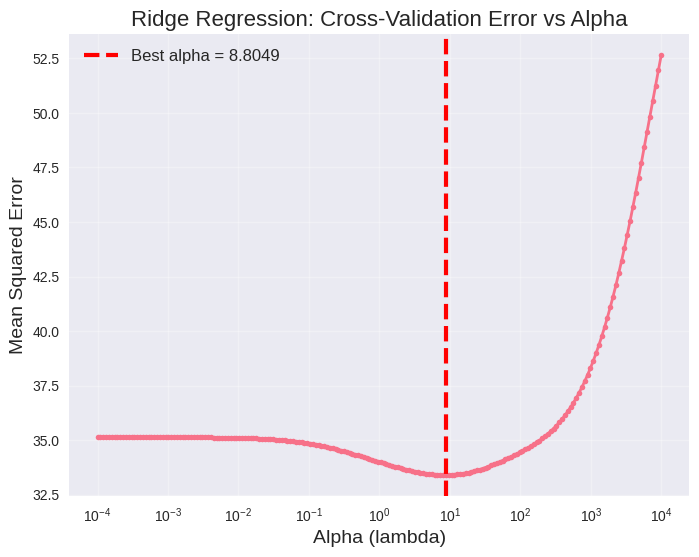

In [32]:
# Cross-validation for Ridge regression
# Define alpha values (equivalent to lambda in R)
alphas = np.logspace(-4, 4, 200)  # Similar to nlambda=200 in R

# Create RidgeCV object
ridge_cv = RidgeCV(
    alphas=alphas,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # equivalent to type.measure="mse"
)

# Fit the model
ridge_cv.fit(X_train, y_train)

# Get the best alpha
best_alpha_ridge = ridge_cv.alpha_
print(f"Best alpha (lambda) for Ridge regression: {best_alpha_ridge}")

# To plot cross-validation results, we need to manually perform cross-validation
from sklearn.model_selection import cross_val_score

# Calculate CV scores for each alpha
cv_scores = []
for alpha in alphas:
    ridge_temp = Ridge(alpha=alpha)
    scores = cross_val_score(ridge_temp, X_train, y_train, cv=5, 
                           scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())  # Convert back to MSE

# Plot cross-validation results
plt.figure(figsize=(8, 6))
plt.semilogx(alphas, cv_scores, marker='o', linewidth=2, markersize=4)
plt.axvline(x=best_alpha_ridge, color='red', linestyle='--', linewidth=3,
           label=f'Best alpha = {best_alpha_ridge:.4f}')
plt.xlabel('Alpha (lambda)', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.title('Ridge Regression: Cross-Validation Error vs Alpha', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

#### Fit Ridge Regression

In [34]:
# Fit Ridge regression with the best alpha
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)

# Display model coefficients
ridge_coef = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_model.coef_
})
print("Ridge Regression Coefficients:")
print(ridge_coef.sort_values('Coefficient', key=abs, ascending=False).to_string(index=False))
print(f"\nIntercept: {ridge_model.intercept_:.4f}")

# Calculate percentage of deviance explained (similar to R-squared)
y_train_pred_ridge = ridge_model.predict(X_train)
r2_ridge_train = r2_score(y_train, y_train_pred_ridge)
print(f"\nR-squared (training): {r2_ridge_train:.4f}")

Ridge Regression Coefficients:
        Feature  Coefficient
  Land_type_MHL     2.582347
            SpH     1.026547
            WpH     0.957253
Year_Irrigation     0.891714
            WEc     0.691177
            SOC     0.593182
            WFe     0.582924
            WAs     0.550854
      Elevation    -0.303572
             WP    -0.196543
   Distance_STW    -0.169748
      Silt_Sand    -0.134151
             SP     0.008702
          SAoFe    -0.000988

Intercept: 3.6736

R-squared (training): 0.5252


#### Prediction on Test Data

In [35]:
# Make predictions on the test data
y_test_pred_ridge = ridge_model.predict(X_test)

# Calculate performance metrics
def calculate_metrics_python(y_true, y_pred):
    """Calculate regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    medae = np.median(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'MedAE': medae,
        'R2': r2
    }

# Calculate metrics
ridge_metrics = calculate_metrics_python(y_test, y_test_pred_ridge)

print("Ridge Regression Performance on Test Data:")
for metric, value in ridge_metrics.items():
    print(f"{metric}: {value:.4f}")

# Create DataFrame with observed and predicted values
ridge_pred_df = pd.DataFrame({
    'Obs_SAs': y_test,
    'Pred_SAs': y_test_pred_ridge
})
print("\nFirst 10 predictions:")
print(ridge_pred_df.head(10))

Ridge Regression Performance on Test Data:
RMSE: 4.8652
MAE: 3.6893
MSE: 23.6704
MedAE: 2.7768
R2: 0.3961

First 10 predictions:
   Obs_SAs   Pred_SAs
0    23.20  25.241081
1    23.80  22.375483
2    30.19  32.709483
3    20.19  22.085979
4    16.40  17.129935
5    11.40  16.681102
6    19.90  20.165222
7    12.40  15.327617
8    26.80  29.116484
9    16.80  19.778058


#### 1:1 Plot of Predicted vs Observed values

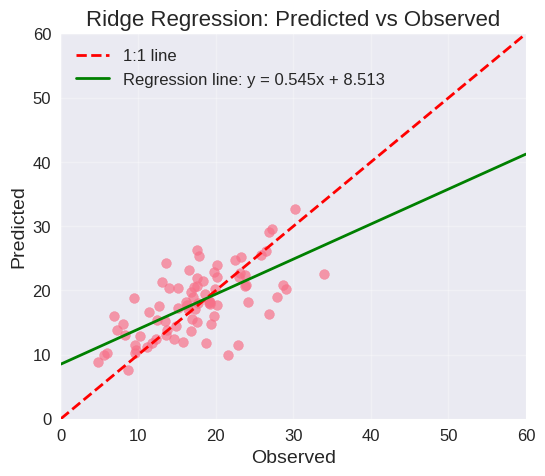

Correlation coefficient (r): 0.6589
R-squared: 0.4342
Adjusted R-squared: 0.3123


In [37]:
# Create 1:1 plot
plt.figure(figsize=(6, 5))
plt.scatter(ridge_pred_df['Obs_SAs'], ridge_pred_df['Pred_SAs'], alpha=0.7, s=50)
plt.plot([0, 60], [0, 60], 'r--', linewidth=2, label='1:1 line')

# Add regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(
    ridge_pred_df['Obs_SAs'], ridge_pred_df['Pred_SAs'])
x_line = np.array([0, 60])
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'g-', linewidth=2, 
         label=f'Regression line: y = {slope:.3f}x + {intercept:.3f}')

plt.xlim(0, 60)
plt.ylim(0, 60)
plt.xticks(range(0, 61, 10), fontsize=12)
plt.yticks(range(0, 61, 10), fontsize=12)
plt.xlabel('Observed', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.title('Ridge Regression: Predicted vs Observed', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Correlation coefficient (r): {r_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"Adjusted R-squared: {1 - (1-r_value**2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1):.4f}")

### Lasso Regression

#### Cross-validation for the best Lasso regression

Best alpha (lambda) for Lasso regression: 0.09771241535346502


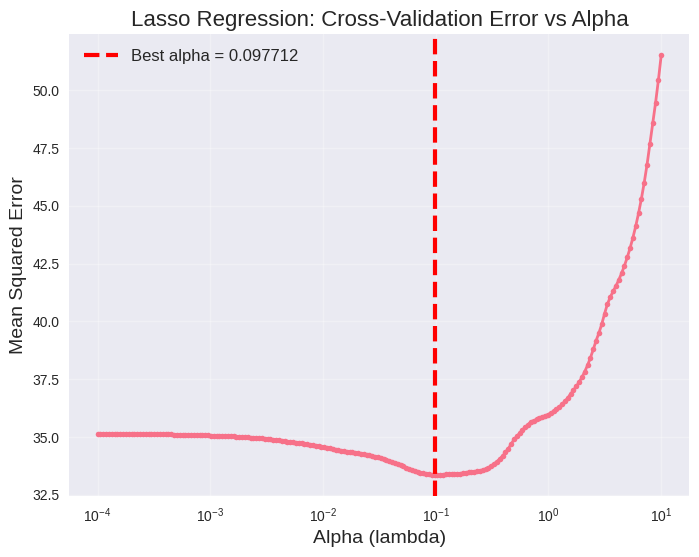

In [39]:
# Cross-validation for Lasso regression
alphas = np.logspace(-4, 1, 200)  # Adjusted range for Lasso

# Create LassoCV object
lasso_cv = LassoCV(
    alphas=alphas,
    cv=5,  # 5-fold cross-validation
    random_state=42,
    max_iter=10000  # Increase max iterations for convergence
)

# Fit the model
lasso_cv.fit(X_train, y_train)

# Get the best alpha
best_alpha_lasso = lasso_cv.alpha_
print(f"Best alpha (lambda) for Lasso regression: {best_alpha_lasso}")

# Plot cross-validation results
plt.figure(figsize=(8, 6))
plt.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1), marker='o', linewidth=2, markersize=4)
plt.axvline(x=best_alpha_lasso, color='red', linestyle='--', linewidth=3,
           label=f'Best alpha = {best_alpha_lasso:.6f}')
plt.xlabel('Alpha (lambda)', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.title('Lasso Regression: Cross-Validation Error vs Alpha', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

#### Fit Lasso Regression

In [40]:
# Fit Lasso regression with the best alpha
lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_model.fit(X_train, y_train)

# Display model coefficients
lasso_coef = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_model.coef_
})
print("Lasso Regression Coefficients:")
print(lasso_coef.sort_values('Coefficient', key=abs, ascending=False).to_string(index=False))
print(f"\nIntercept: {lasso_model.intercept_:.4f}")

# Show which coefficients are zero (feature selection)
zero_coef = lasso_coef[lasso_coef['Coefficient'] == 0]
non_zero_coef = lasso_coef[lasso_coef['Coefficient'] != 0]
print(f"\nNumber of features selected: {len(non_zero_coef)} out of {len(lasso_coef)}")
print(f"Features with zero coefficients: {len(zero_coef)}")

if len(zero_coef) > 0:
    print("\nFeatures eliminated by Lasso:")
    print(zero_coef['Feature'].tolist())
    
# Show non-zero coefficients
print("\nNon-zero coefficients:")
print(non_zero_coef.sort_values('Coefficient', key=abs, ascending=False).to_string(index=False))

Lasso Regression Coefficients:
        Feature  Coefficient
  Land_type_MHL     2.986705
Year_Irrigation     0.880713
            WEc     0.592678
            WFe     0.521923
            SpH     0.440013
      Elevation    -0.263443
   Distance_STW    -0.166412
      Silt_Sand    -0.138886
             SP     0.009798
          SAoFe    -0.001007
            WpH     0.000000
             WP    -0.000000
            WAs     0.000000
            SOC     0.000000

Intercept: 16.2173

Number of features selected: 10 out of 14
Features with zero coefficients: 4

Features eliminated by Lasso:
['WAs', 'WP', 'WpH', 'SOC']

Non-zero coefficients:
        Feature  Coefficient
  Land_type_MHL     2.986705
Year_Irrigation     0.880713
            WEc     0.592678
            WFe     0.521923
            SpH     0.440013
      Elevation    -0.263443
   Distance_STW    -0.166412
      Silt_Sand    -0.138886
             SP     0.009798
          SAoFe    -0.001007


#### Prediction on Test Data

In [41]:
# Make predictions on the test data
y_test_pred_lasso = lasso_model.predict(X_test)

# Calculate performance metrics
lasso_metrics = calculate_metrics_python(y_test, y_test_pred_lasso)

print("Lasso Regression Performance on Test Data:")
for metric, value in lasso_metrics.items():
    print(f"{metric}: {value:.4f}")

# Create DataFrame with observed and predicted values
lasso_pred_df = pd.DataFrame({
    'Obs_SAs': y_test,
    'Pred_SAs': y_test_pred_lasso
})
print("\nFirst 10 predictions:")
print(lasso_pred_df.head(10))

Lasso Regression Performance on Test Data:
RMSE: 4.9265
MAE: 3.7550
MSE: 24.2704
MedAE: 2.7673
R2: 0.3808

First 10 predictions:
   Obs_SAs   Pred_SAs
0    23.20  25.375166
1    23.80  22.471301
2    30.19  32.665061
3    20.19  22.004325
4    16.40  17.118105
5    11.40  16.615664
6    19.90  20.230618
7    12.40  15.604670
8    26.80  29.042521
9    16.80  19.552331


#### 1:1 Plot of Predicted vs Observed values

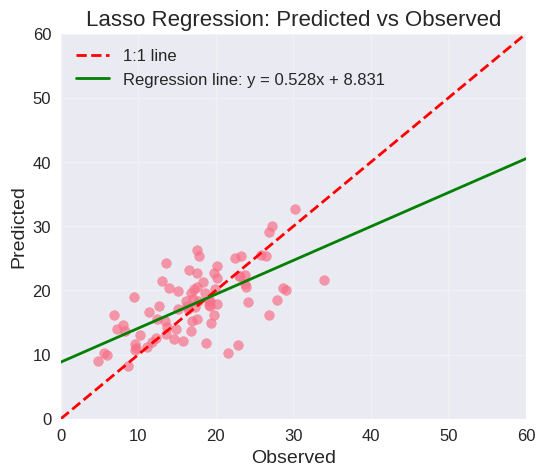

Correlation coefficient (r): 0.6475
R-squared: 0.4193
Adjusted R-squared: 0.2942


In [42]:
# Create 1:1 plot
plt.figure(figsize=(6, 5))
plt.scatter(lasso_pred_df['Obs_SAs'], lasso_pred_df['Pred_SAs'], alpha=0.7, s=50)
plt.plot([0, 60], [0, 60], 'r--', linewidth=2, label='1:1 line')

# Add regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(
    lasso_pred_df['Obs_SAs'], lasso_pred_df['Pred_SAs'])
x_line = np.array([0, 60])
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'g-', linewidth=2, 
         label=f'Regression line: y = {slope:.3f}x + {intercept:.3f}')

plt.xlim(0, 60)
plt.ylim(0, 60)
plt.xticks(range(0, 61, 10), fontsize=12)
plt.yticks(range(0, 61, 10), fontsize=12)
plt.xlabel('Observed', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.title('Lasso Regression: Predicted vs Observed', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Correlation coefficient (r): {r_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"Adjusted R-squared: {1 - (1-r_value**2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1):.4f}")

### Elastic Net Regression

Elastic Net regression is a combination of L1 (Lasso) and L2 (Ridge) regularization. It provides a balance between feature selection and coefficient shrinkage.

#### Cross-validation for the best Elastic Net regression

Best alpha (lambda) for Elastic Net: 0.10722672220103231
Best l1_ratio (alpha mixing parameter) for Elastic Net: 0.9


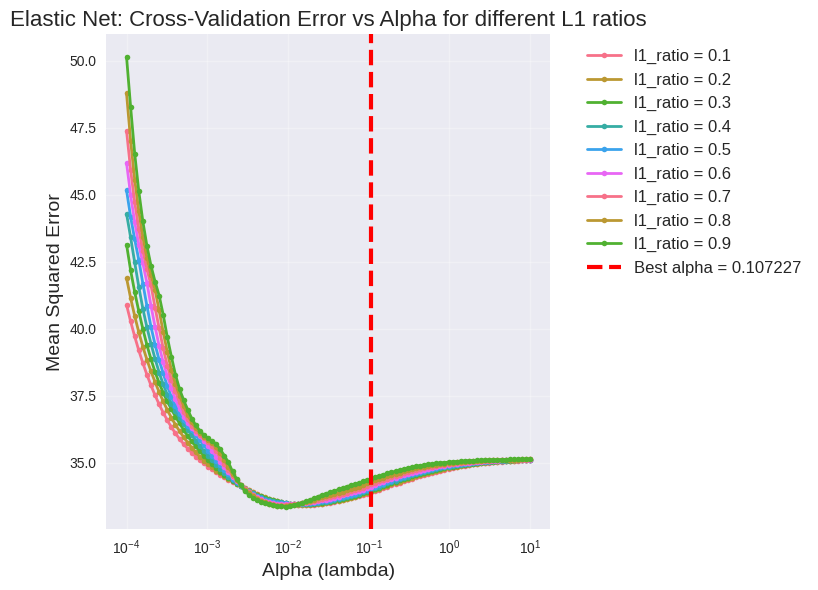

In [44]:
# Define alpha values for Elastic Net (mixing parameter)
l1_ratios = np.arange(0.1, 1.0, 0.1)  # Equivalent to alpha in glmnet

# Define lambda values (called alpha in sklearn)
alphas = np.logspace(-4, 1, 100)

# Create ElasticNetCV object
elastic_net_cv = ElasticNetCV(
    l1_ratio=l1_ratios,
    alphas=alphas,
    cv=5,  # 5-fold cross-validation
    random_state=42,
    max_iter=10000
)

# Fit the model
elastic_net_cv.fit(X_train, y_train)

# Get the best parameters
best_alpha_enet = elastic_net_cv.alpha_  # Best lambda
best_l1_ratio = elastic_net_cv.l1_ratio_  # Best alpha (mixing parameter)

print(f"Best alpha (lambda) for Elastic Net: {best_alpha_enet}")
print(f"Best l1_ratio (alpha mixing parameter) for Elastic Net: {best_l1_ratio}")

# Plot cross-validation results for different l1_ratios
plt.figure(figsize=(8, 6))

# Get CV results
mse_path = elastic_net_cv.mse_path_

for i, l1_ratio in enumerate(l1_ratios):
    plt.semilogx(alphas, mse_path[i].mean(axis=1), 
                label=f'l1_ratio = {l1_ratio:.1f}', marker='o', linewidth=2, markersize=4)

plt.axvline(x=best_alpha_enet, color='red', linestyle='--', linewidth=3,
           label=f'Best alpha = {best_alpha_enet:.6f}')
plt.xlabel('Alpha (lambda)', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.title('Elastic Net: Cross-Validation Error vs Alpha for different L1 ratios', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Fit Elastic Net Regression

In [45]:
# Fit Elastic Net regression with the best parameters
elastic_net_model = ElasticNet(
    alpha=best_alpha_enet,
    l1_ratio=best_l1_ratio,
    max_iter=10000,
    random_state=42
)
elastic_net_model.fit(X_train, y_train)

# Display model coefficients
elastic_net_coef = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': elastic_net_model.coef_
})
print("Elastic Net Regression Coefficients:")
print(elastic_net_coef.sort_values('Coefficient', key=abs, ascending=False).to_string(index=False))
print(f"\nIntercept: {elastic_net_model.intercept_:.4f}")

# Show which coefficients are zero
zero_coef_enet = elastic_net_coef[elastic_net_coef['Coefficient'] == 0]
non_zero_coef_enet = elastic_net_coef[elastic_net_coef['Coefficient'] != 0]
print(f"\nNumber of features selected: {len(non_zero_coef_enet)} out of {len(elastic_net_coef)}")
print(f"Features with zero coefficients: {len(zero_coef_enet)}")

if len(zero_coef_enet) > 0:
    print("\nFeatures eliminated by Elastic Net:")
    print(zero_coef_enet['Feature'].tolist())
    
# Show non-zero coefficients
print("\nNon-zero coefficients:")
print(non_zero_coef_enet.sort_values('Coefficient', key=abs, ascending=False).to_string(index=False))

Elastic Net Regression Coefficients:
        Feature  Coefficient
  Land_type_MHL     2.795334
Year_Irrigation     0.881957
            WEc     0.601707
            WFe     0.531588
            SpH     0.397066
      Elevation    -0.288720
   Distance_STW    -0.166178
      Silt_Sand    -0.139908
             SP     0.011363
          SAoFe    -0.001040
            WpH     0.000000
             WP    -0.000000
            WAs     0.000000
            SOC     0.000000

Intercept: 16.8194

Number of features selected: 10 out of 14
Features with zero coefficients: 4

Features eliminated by Elastic Net:
['WAs', 'WP', 'WpH', 'SOC']

Non-zero coefficients:
        Feature  Coefficient
  Land_type_MHL     2.795334
Year_Irrigation     0.881957
            WEc     0.601707
            WFe     0.531588
            SpH     0.397066
      Elevation    -0.288720
   Distance_STW    -0.166178
      Silt_Sand    -0.139908
             SP     0.011363
          SAoFe    -0.001040


#### Prediction on Test Data

In [47]:
# Make predictions on the test data
y_test_pred_enet = elastic_net_model.predict(X_test)

# Calculate performance metrics
elastic_net_metrics = calculate_metrics_python(y_test, y_test_pred_enet)

print("Elastic Net Regression Performance on Test Data:")
for metric, value in elastic_net_metrics.items():
    print(f"{metric}: {value:.4f}")

# Create DataFrame with observed and predicted values
elastic_net_pred_df = pd.DataFrame({
    'Obs_SAs': y_test,
    'Pred_SAs': y_test_pred_enet
})
print("\nFirst 10 predictions:")
print(elastic_net_pred_df.head(10))

Elastic Net Regression Performance on Test Data:
RMSE: 4.9253
MAE: 3.7559
MSE: 24.2587
MedAE: 2.7918
R2: 0.3811

First 10 predictions:
   Obs_SAs   Pred_SAs
0    23.20  25.353703
1    23.80  22.448149
2    30.19  32.666902
3    20.19  21.966139
4    16.40  17.030079
5    11.40  16.585579
6    19.90  20.195687
7    12.40  15.548250
8    26.80  29.022679
9    16.80  19.497945


#### 1:1 Plot of Predicted vs Observed values

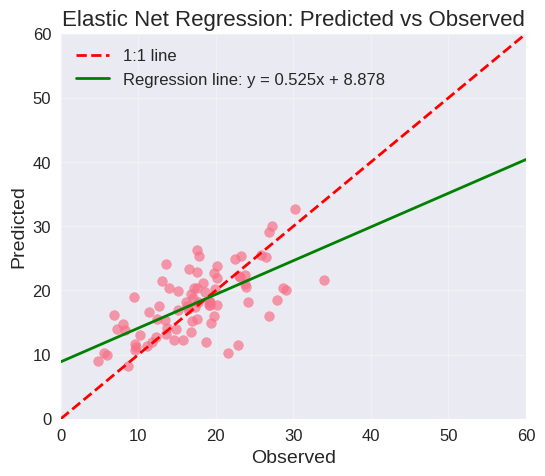

Correlation coefficient (r): 0.6468
R-squared: 0.4184
Adjusted R-squared: 0.2931


In [48]:
# Create 1:1 plot
plt.figure(figsize=(6, 5))
plt.scatter(elastic_net_pred_df['Obs_SAs'], elastic_net_pred_df['Pred_SAs'], alpha=0.7, s=50)
plt.plot([0, 60], [0, 60], 'r--', linewidth=2, label='1:1 line')

# Add regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(
    elastic_net_pred_df['Obs_SAs'], elastic_net_pred_df['Pred_SAs'])
x_line = np.array([0, 60])
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'g-', linewidth=2, 
         label=f'Regression line: y = {slope:.3f}x + {intercept:.3f}')

plt.xlim(0, 60)
plt.ylim(0, 60)
plt.xticks(range(0, 61, 10), fontsize=12)
plt.yticks(range(0, 61, 10), fontsize=12)
plt.xlabel('Observed', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.title('Elastic Net Regression: Predicted vs Observed', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Correlation coefficient (r): {r_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"Adjusted R-squared: {1 - (1-r_value**2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1):.4f}")

### Compare All Models

Model Comparison:
               RMSE     MAE      MSE   MedAE      R2
Ridge        4.8652  3.6893  23.6704  2.7768  0.3961
Lasso        4.9265  3.7550  24.2704  2.7673  0.3808
Elastic Net  4.9253  3.7559  24.2587  2.7918  0.3811


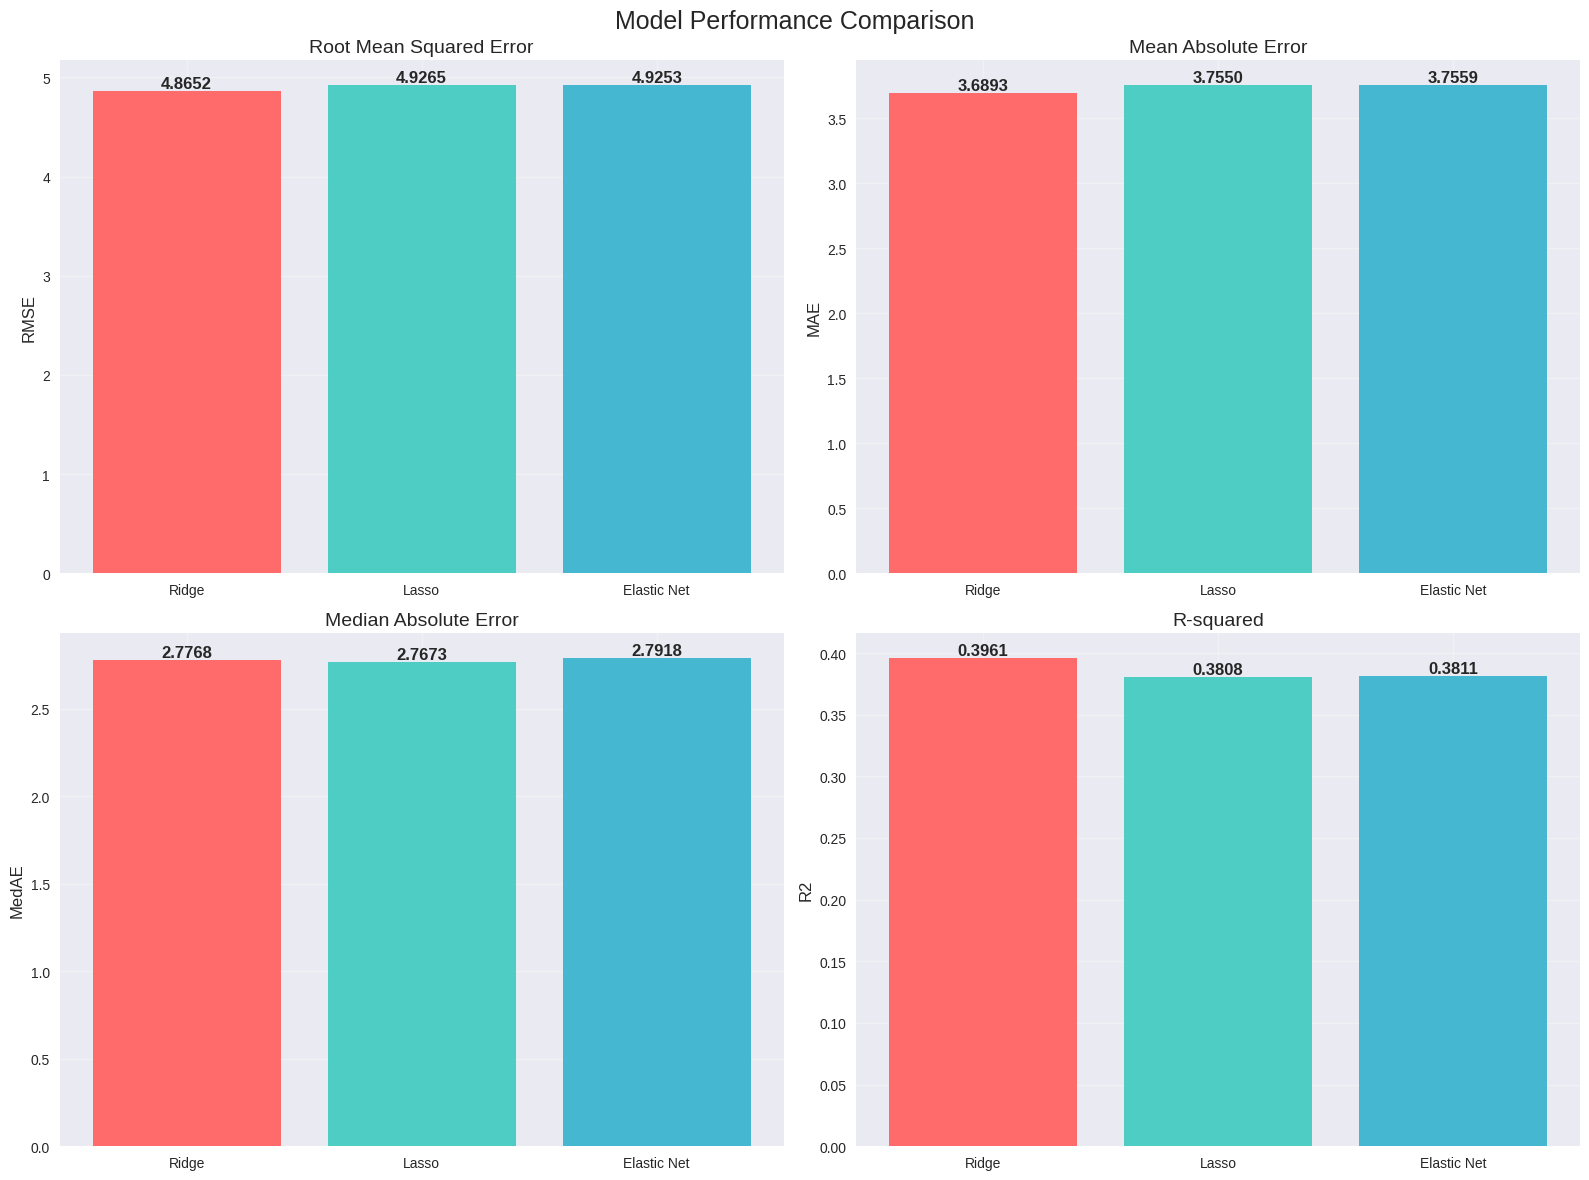

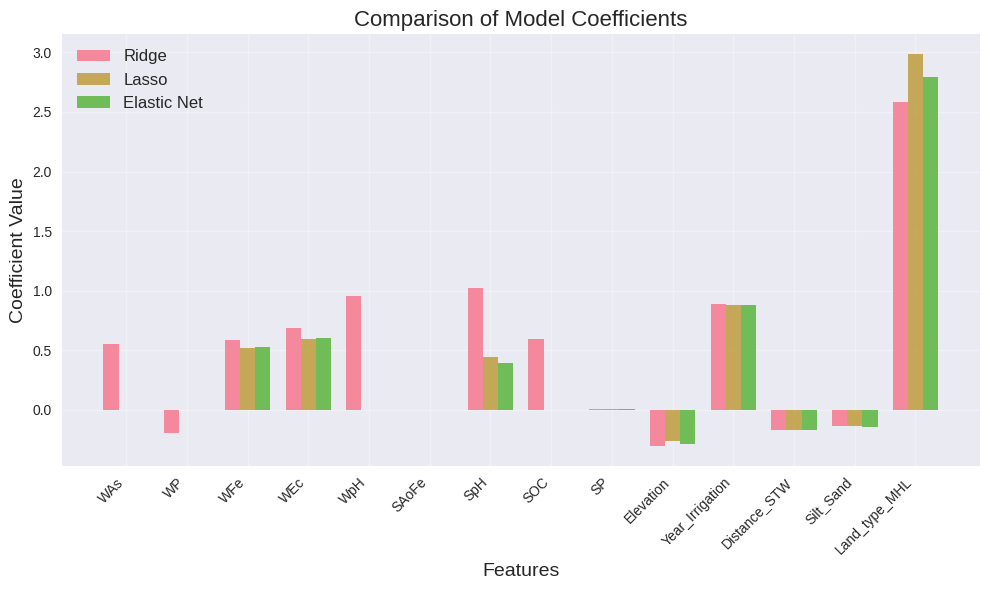

In [50]:
# Create comparison table
models = ['Ridge', 'Lasso', 'Elastic Net']
metrics_list = [ridge_metrics, lasso_metrics, elastic_net_metrics]

comparison_df = pd.DataFrame(metrics_list, index=models)
print("Model Comparison:")
print(comparison_df.round(4))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=18)

metrics_to_plot = ['RMSE', 'MAE', 'MedAE', 'R2']
titles = ['Root Mean Squared Error', 'Mean Absolute Error', 'Median Absolute Error', 'R-squared']

for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[i//2, i%2]
    values = [metrics[metric] for metrics in metrics_list]
    bars = ax.bar(models, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(metric, fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for j, v in enumerate(values):
        ax.text(j, v, f'{v:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Create coefficient comparison plot
plt.figure(figsize=(10, 6))

# Get coefficients for all models
ridge_coefs = ridge_model.coef_
lasso_coefs = lasso_model.coef_
elastic_net_coefs = elastic_net_model.coef_

x = np.arange(len(X_train.columns))
width = 0.25

plt.bar(x - width, ridge_coefs, width, label='Ridge', alpha=0.8)
plt.bar(x, lasso_coefs, width, label='Lasso', alpha=0.8)
plt.bar(x + width, elastic_net_coefs, width, label='Elastic Net', alpha=0.8)

plt.xlabel('Features', fontsize=14)
plt.ylabel('Coefficient Value', fontsize=14)
plt.title('Comparison of Model Coefficients', fontsize=16)
plt.xticks(x, X_train.columns, rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary and Conclusions

Regularized linear regression (GLM with a Gaussian distribution) helps prevent overfitting by shrinking the coefficient estimates, which can lead to simpler, more interpretable models. The choice of regularization method (L1, L2, or Elastic Net) depends on whether you need feature selection (L1), smoothness (L2), or a balance of both (Elastic Net). Although these methods may seem similar, they have significant differences. Ridge regression uses the square of the coefficients as a penalty, while Lasso regression uses the absolute value of the coefficients. Elastic Net regression combines the penalties of both Ridge and Lasso regression.

This tutorial explored how to implement Regularized Linear Models (GLMs) in Python using scikit-learn. Regularized GLMs, such as LASSO, Ridge, and Elastic Net, are essential techniques in predictive modeling, especially when dealing with high-dimensional data or collinear predictors.

**Key takeaways:**

1. **Ridge Regression (L2)**: Shrinks coefficients toward zero but rarely sets them exactly to zero. Good for handling multicollinearity and when you believe all predictors have some effect.

2. **Lasso Regression (L1)**: Can set coefficients exactly to zero, performing automatic feature selection. Useful when you have many predictors and want a sparse model.

3. **Elastic Net**: Combines L1 and L2 penalties, offering a balance between feature selection and coefficient shrinkage. Particularly useful when you have groups of correlated variables.

4. **Cross-validation**: Essential for selecting the optimal regularization parameter (λ or alpha in sklearn). The `cv.glmnet` equivalent in Python is handled by `RidgeCV`, `LassoCV`, and `ElasticNetCV`.

5. **Data preprocessing**: Standardization is crucial for regularized regression models to ensure fair penalty application across all features.

To summarize, scikit-learn provides robust, well-documented implementations of regularized GLMs in Python. Factors such as the dataset size, desired modeling workflow, and personal preference should be considered when choosing a regularization method. By mastering these techniques, researchers and data scientists can effectively use regularized GLMs for predictive modeling tasks, extracting valuable insights from complex datasets while mitigating overfitting and improving generalization performance.

## Resources

1. [Scikit-learn Documentation: Linear Models](https://scikit-learn.org/stable/modules/linear_model.html)
2. [Lasso and Elastic-Net Regularized Generalized Linear Models](https://glmnet.stanford.edu/index.html)
3. [Ridge, Lasso, and Elastic Net Regression using glmnet](https://rpubs.com/jmkelly91/881590)
4. [Linear Model Selection and Regularization](https://emilhvitfeldt.github.io/ISLR-tidymodels-labs/06-regularization.html)